In [1]:
import random
from pymongo import MongoClient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from scripts import MONGO_URL, END_DATE, GITHUB_TOKENS
from scripts.analysis import data, plot

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

plot.init_matplotlib()

W, H = 6, 2.5

In [2]:
client = MongoClient(MONGO_URL)
db = client['fake_stars']
# collection = db['fake_actor_events']
collection = db['fake_actor_events']
documents = list(collection.find({}))

df = pd.DataFrame(documents)


repos_with_campaign = data.get_repos_with_campaign()
low_activity_actors_in_campaign = data.get_unique_actors(
    "low_activity_stars",
    {"low_activity": True, "repo": {"$in": list(repos_with_campaign)}},
)
clustered_actors_in_campaign = data.get_unique_actors(
    "clustered_stars", {"clustered": True, "repo": {"$in": list(repos_with_campaign)}},)

df = df[df.actor.isin(low_activity_actors_in_campaign |
                      clustered_actors_in_campaign)]



def compute_actor_features(df):
    # Group by actor and calculate total and activity-specific counts
    actor_group = df.groupby('actor').agg(
        total_activities=('type', 'count'),
        stars=('type', lambda x: (x == 'WatchEvent').sum()),
        issues=('type', lambda x: (x == 'IssuesEvent').sum()),
        prs=('type', lambda x: (x == 'PullRequestEvent').sum()),
        creates=('type', lambda x: (x == 'CreateEvent').sum()),
        forks=('type', lambda x: (x == 'ForkEvent').sum()),
        pushs=('type', lambda x: (x == 'PushEvent').sum()),
        comments=('type', lambda x: ((x.str.contains('Comment'))
                  | x.str.contains('Review')).sum())
    ).reset_index()
    N = actor_group['total_activities']
    # Calculate the percentages of each activity type
    actor_group['star_ratio'] = actor_group['stars'] / N

    actor_group['issue_ratio'] = actor_group['issues'] / N

    actor_group['pr_ratio'] = actor_group['prs'] / N

    actor_group['create_ratio'] = actor_group['creates'] / N

    actor_group['fork_ratio'] = actor_group['forks'] / N

    actor_group['push_ratio'] = actor_group['pushs'] / N

    actor_group['comment_ratio'] = actor_group['comments'] / N
    actor_group['other_ratio'] = 1 - (actor_group['star_ratio'] + actor_group['issue_ratio']
                                      + actor_group['pr_ratio'] +
                                      actor_group['create_ratio']
                                      + actor_group['fork_ratio'] +
                                      actor_group['push_ratio']
                                      + actor_group['comment_ratio'])
    actor_group.fillna(0, inplace=True)

    return actor_group


# Compute the features
actor_features = compute_actor_features(df)

features = actor_features[['star_ratio', 'issue_ratio', 'pr_ratio', 'comment_ratio',
                           'create_ratio', 'fork_ratio', 'push_ratio', 'other_ratio']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


In [3]:
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.cluster import SpectralClustering
from multiprocessing import Pool
from sklearn.cluster import DBSCAN
k_values = range(2, 8)

# List to store the silhouette scores for each k
silhouette_scores = []
silhouette_scores_kmeans = []

# def get_silhouette_scores(k, features):
#     speatral_model = SpectralClustering(
#         n_clusters=k, random_state=42, assign_labels='kmeans',
#         affinity='nearest_neighbors').fit(features)
#     labels = speatral_model.labels_
#     return metrics.silhouette_score(features, labels, metric='euclidean')


# with Pool(len(k_values)) as pool:
#    silhouette_scores = pool.starmap(
#        get_silhouette_scores, [(k, scaled_features) for k in k_values])
for k in k_values:
    speatral_model = SpectralClustering(n_clusters=k, random_state=42, assign_labels='kmeans',
                                        affinity='nearest_neighbors').fit(scaled_features)
    labels = speatral_model.labels_
    score = metrics.silhouette_score(
        scaled_features, labels, metric='euclidean')
    
    kmeans_model = KMeans(n_clusters=k).fit(scaled_features)
    labels = kmeans_model.labels_
    score2 = metrics.silhouette_score(
        scaled_features, labels, metric='euclidean')

    print(k, score, score2)
    silhouette_scores.append(score)
    silhouette_scores_kmeans.append(score2)


2 0.38985972764930443 0.7016587168977034
3 0.44030745626654927 0.7080570682381268
4 0.49259729054279255 0.726113436157304
5 0.5373040421345862 0.6193958411846567
6 0.5532606998846493 0.7298958594041284
7 0.5554496084248391 0.734604968605193


In [11]:
# spectral clustering algorithm
from sklearn.cluster import SpectralClustering
spectral_clustering = SpectralClustering(
    n_clusters=4,
    random_state=42,
    assign_labels='kmeans',  # Options: 'kmeans' or 'discretize'
    affinity='nearest_neighbors'  # Options: 'rbf', 'nearest_neighbors', 'precomputed'
)

# Fit and predict cluster labels
actor_features['cluster'] = spectral_clustering.fit_predict(scaled_features)
ratio_columns = ['star_ratio', 'issue_ratio', 'pr_ratio', 'create_ratio',
                 'fork_ratio', 'push_ratio', 'comment_ratio','other_ratio', "total_activities"]

cluster_means = actor_features.groupby('cluster')[ratio_columns].mean()

# Print the cluster means
print(cluster_means)
cluster_counts = actor_features.groupby('cluster').size().reset_index(name='actor_count')
print(cluster_counts)


         star_ratio  issue_ratio  pr_ratio  create_ratio  fork_ratio  \
cluster                                                                
0          0.621473     0.012260  0.014792      0.106123    0.034462   
1          0.999936     0.000004  0.000000      0.000011    0.000041   
2          0.493460     0.000062  0.000000      0.000754    0.504415   
3          0.990433     0.000000  0.000000      0.008958    0.000330   

         push_ratio  comment_ratio   other_ratio  total_activities  
cluster                                                             
0          0.177432       0.022427  1.103009e-02        550.077409  
1          0.000007       0.000000  1.135197e-19         22.916155  
2          0.001246       0.000062  0.000000e+00         21.250000  
3          0.000278       0.000000  0.000000e+00        560.910112  
   cluster  actor_count
0        0          633
1        1          978
2        2          116
3        3           89


In [5]:
# Kmeans clustering algorithm
from sklearn.cluster import kmeans_plusplus
actor_features['cluster']  = KMeans(n_clusters=4).fit_predict(scaled_features)

ratio_columns = ['star_ratio', 'issue_ratio', 'pr_ratio', 'create_ratio',
                 'fork_ratio', 'push_ratio', 'comment_ratio','other_ratio', "total_activities"]

cluster_means = actor_features.groupby('cluster')[ratio_columns].mean()

# Print the cluster means
print(cluster_means)
cluster_counts = actor_features.groupby('cluster').size().reset_index(name='actor_count')
print(cluster_counts)

         star_ratio  issue_ratio  pr_ratio  create_ratio  fork_ratio  \
cluster                                                                
0          0.959003     0.001122  0.000619      0.019134    0.006631   
1          0.291823     0.010629  0.032559      0.180187    0.021402   
2          0.281965     0.124702  0.047685      0.050262    0.028472   
3          0.516501     0.000164  0.000223      0.003872    0.474148   

         push_ratio  comment_ratio  other_ratio  total_activities  
cluster                                                            
0          0.011011       0.001801     0.000679        134.614794  
1          0.420278       0.017230     0.025892        836.392523  
2          0.197524       0.254270     0.015119       1512.870968  
3          0.004705       0.000387     0.000000         30.485507  
   cluster  actor_count
0        0         1433
1        1          214
2        2           31
3        3          138


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, SpectralEmbedding

unique_clusters = [0,1,2,3]
perplexities = [10, 20, 30, 50, 100]
tsne_df = {}
for p in perplexities:
    tsne = TSNE(n_components=2, perplexity=p, max_iter=1000, random_state=42)
    tsne_results = tsne.fit_transform(scaled_features)

    tsne_df[p] = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
    tsne_df[p]['cluster'] = actor_features['cluster']

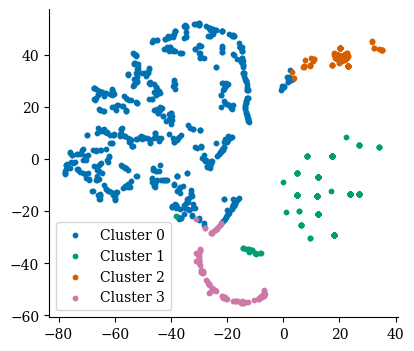

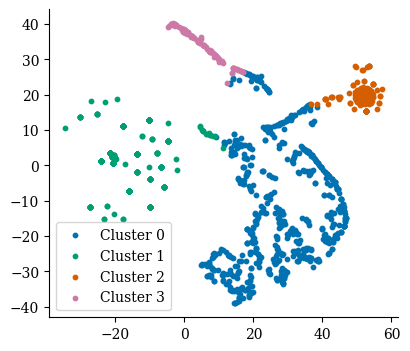

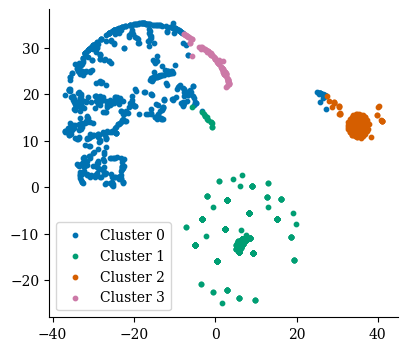

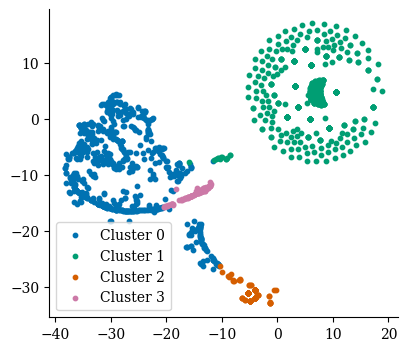

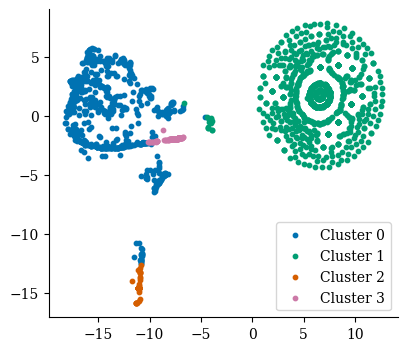

In [28]:

import matplotlib.pyplot as plt

color_dict = {0: "C0", 1: "C1", 2: "C2", 3:"C3", 4:"C4"}

for p in perplexities:
    fig, ax = plt.subplots(1, 1, figsize=(4.5, 4))
    ax.grid(False)
    for cluster in unique_clusters:
        cluster_data = tsne_df[p][tsne_df[p]['cluster'] == cluster]
        
        ax.scatter(
            cluster_data['TSNE1'],
            cluster_data['TSNE2'],
            c=[color_dict[cluster]],    # Color assigned to this cluster
            label=f'Cluster {cluster}', # Label for the legend
            s=10,                       # Marker size; adjust as needed
            marker='o'
        )

    ax.legend()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    fig.savefig(f"plots/tsne-users-{p}.pdf", bbox_inches="tight", dpi=300)